## Section 2.2 - ICP applied on moderate dataset

### Imports

In [2]:
import copy
import numpy as np
import pandas as pd
import open3d as o3d
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import matplotlib.animation as animation

!pip install ipython-autotime
%load_ext autotime

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
time: 0 ns (started: 2024-11-18 22:55:48 -03:00)


### Functions

In [4]:
def plot_2d(x, y, label, axis = None):
    if axis:
        ax = axis
    else:
        ax = plt.gca()
    ax.scatter(x,y, s=0.6)
    ax.set_ylim(-8, 8)
    ax.set_xlim(-8, 8)
    ax.plot(0, 0, 'ro')
    ax.set_title(label)
    ax.grid()
    ax.set_aspect('equal')
    if not axis:
        plt.show()
  
def kdtree_nearest_neighbor(P, Q):
    '''
    Find the nearest (Euclidean) neighbor in dst for each point in src by KDTree search (faster)
    Input:
        src: Nxm array of points
        dst: Nxm array of points
    Output:
        List:
          indices of point cloud P
          indices of mathced point cloud Q
          distance
    '''
    tree = KDTree(Q.T)
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        nearest_dist, nearest_ind = tree.query([p_point], k=2)  # k=2 nearest neighbors where k1 = identity
        d = nearest_dist[:,1][0]
        j = nearest_ind[:,1][0]
        correspondences.append((i, j, d))
    return correspondences

def convert_xyz_to_pcd(input_df, output_file):
    # Pass xyz to Open3D.o3d.geometry.PointCloud and visualize
    if 'z' not in input_df.columns:
        input_df['z']=0
    if 'ones' in input_df.columns:
        del input_df['ones']
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(input_df.to_numpy())

    # Salvar no formato .pcd
    o3d.io.write_point_cloud(output_file, pcd)

time: 16 ms (started: 2024-11-18 22:56:01 -03:00)


### Open Dataset

In [5]:
df = pd.read_csv("./sample_data/t_x_y_z.csv", names=["time","x","y","z"], header=None)
df.tail(5)

,time,x,y,z
106920,1.731694e+09,-2.149800,-2.333729,0.0
106921,1.731694e+09,-2.198899,-2.342693,0.0
106922,1.731694e+09,-2.242859,-2.345124,0.0
106923,1.731694e+09,-2.215611,-2.272739,0.0
106924,1.731694e+09,-2.267051,-2.282449,0.0


time: 141 ms (started: 2024-11-18 22:56:03 -03:00)


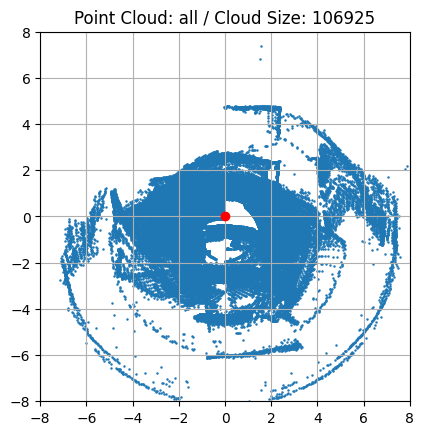

time: 235 ms (started: 2024-11-18 22:56:05 -03:00)


In [6]:
# Create scatter plot
plot_2d(df.x,df.y, f"Point Cloud: all / Cloud Size: {len(df)}")

**DATA PROBLEM #1)** Notice that we have moved the LiDAR origin over a place, we have to separate in $n$ point clouds in order to apply ICP to join them.

Since this Lidar has 6Hz, one complete rotation was done in:

$$
6 = \frac{1}{t} \rightarrow t = 0.166s
$$

**DATA PROBLEM #2)** x=0.0, y=0.0, z-0.0 sensor responses

In [7]:
# How many x=0 , y=0 points? Remember to remove these points later after cloud formation
df.loc[df['x']==0].describe()

,time,x,y,z
count,7.742000e+03,7742.0,7742.0,7742.0
mean,1.731694e+09,0.0,0.0,0.0
std,7.694971e+00,0.0,0.0,0.0
min,1.731694e+09,-0.0,-0.0,0.0
25%,1.731694e+09,0.0,0.0,0.0
50%,1.731694e+09,0.0,0.0,0.0
75%,1.731694e+09,0.0,0.0,0.0
max,1.731694e+09,-0.0,-0.0,0.0


time: 31 ms (started: 2024-11-18 22:56:13 -03:00)


**DATA PROBLEM #1 AND #2 SOLUTION)**

In [8]:
# Split the DataFrame into separate clouds
def select_frame(i):
    start_time = df.time.values[0]
    low_limit = (i-1)*0.1666+start_time
    high_limit = i*0.1666+start_time
    return df[(df['time']>low_limit) & (df['time']<high_limit)]

df2 = select_frame(1)
# n = How many blocks of cloud_size equals 1st frame size fits on the dataset?
n = int(df.index.values[-1]/len(df2))
print(f"{n} frames with {len(df2)} points each")

dfs = [select_frame(i) for i in range(1,n)]
print(f"{len(dfs)} frames with almost {len(df)//len(dfs)} points each")

# Remove x=0, y=0 points
for i in range(len(dfs)):
    idx_to_remove = dfs[i].loc[(dfs[i]['x']==0)].index.values
    dfs[i] = dfs[i].drop(index=idx_to_remove)
    idx_to_remove = dfs[i].loc[(dfs[i]['y']==0)].index.values
    dfs[i] = dfs[i].drop(index=idx_to_remove)
cloud_count = [dfs[i].x.count() for i in range(len(dfs))]
print(f"{len(dfs)} frames with almost {sum(cloud_count)//len(dfs)} points each")

161 frames with 664 points each
160 frames with almost 668 points each
160 frames with almost 618 points each
time: 203 ms (started: 2024-11-18 22:56:16 -03:00)


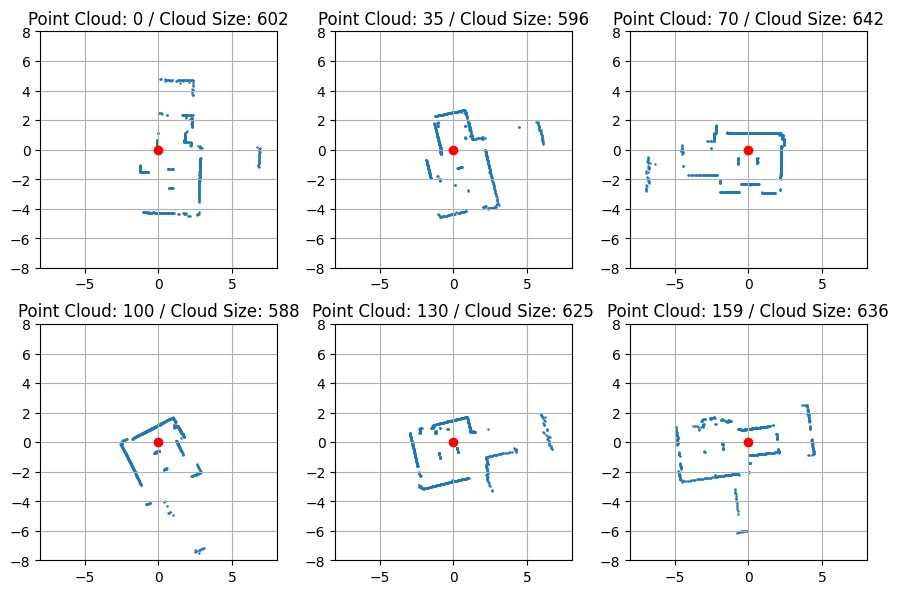

time: 766 ms (started: 2024-11-18 22:56:50 -03:00)


In [11]:
# Check different sensor responses for the same room
fig, axis = plt.subplots(2,3,figsize=(9,6))

# plot 0th point cloud
i = 0
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[0][0])

# plot 35th point cloud
i = 35
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[0][1])

# plot 70th point cloud
i = 70
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[0][2])

# plot 100th point cloud
i = 100
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[1][0])

# plot 150th point cloud
i = 130
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[1][1])

# plot 200th point cloud
i = 159
df2 = dfs[i]
plot_2d(df2.x,df2.y,f"Point Cloud: {i} / Cloud Size: {len(df2)}", axis[1][2])

plt.tight_layout()
plt.show()
cloud_size = len(df2)+1

In [12]:
# Dataset video generator
# Initialize the figure and axis
fig, ax = plt.subplots()
scatter = ax.scatter([], [], s=0.6)
ax.plot(0, 0, 'ro')
ax.set_ylim(-8, 8)
ax.set_xlim(-8, 8)
ax.set_aspect('equal')
ax.grid(True)
title = ax.set_title("")

# Update function for animation
def update(frame):
    df2 = dfs[frame]
    scatter.set_offsets(df2[['x', 'y']].values)  # Update scatter points
    title.set_text(f"Cloud: {frame + 1} / Cloud size: {len(df2)}")  # Update title
    return scatter, title

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(dfs), blit=False, repeat=False
)

# Save the animation as MP4
ani.save('imgs/scatter_animation.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.close(fig)

time: 10.5 s (started: 2024-11-18 22:57:38 -03:00)


Result: <a href="imgs/scatter_animation.mp4">imgs/scatter_animation.mp4</a>


<video controls  height="500" >
      <source src="imgs/scatter_animation.mp4" type="video/mp4">
</video>

### Open3D ICP

#### Apply ICP between 2 (not so much) distant clouds

Initial state is:
RegistrationResult with fitness=2.466443e-01, inlier_rmse=1.799563e-01, and correspondence_set size of 147
Access transformation to get result.

After ICP, state is:
RegistrationResult with fitness=8.557047e-01, inlier_rmse=9.568334e-02, and correspondence_set size of 510
Access transformation to get result.
Transformation is:
[[ 0.97091255  0.23943438  0.          0.73729469]
 [-0.23943438  0.97091255  0.         -0.08346036]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


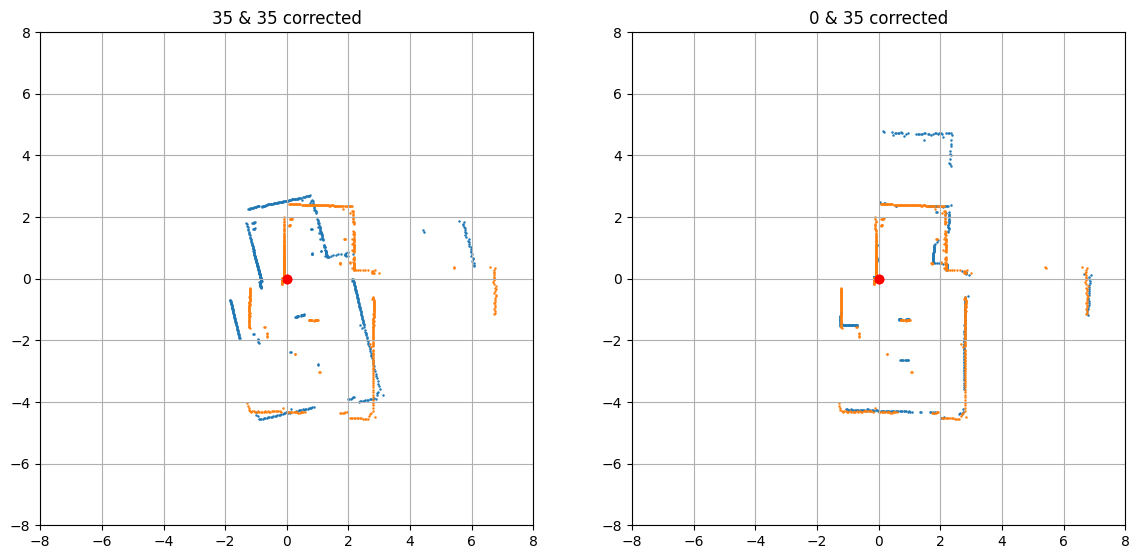

time: 344 ms (started: 2024-11-18 23:12:44 -03:00)


In [19]:
# initializations
for i in range(len(dfs)):
    try:
        del dfs[i]['time'] # remove time column
    except:
        pass

def transform(T,array):
    ones_row = np.ones((1, array.T.shape[1]))
    source_homogeneous = np.append( array.T , ones_row, axis=0)
    return T @ source_homogeneous

def correct_cloud(source_idx,target_idx, sor=(), icp_threshold = 0.3, ignore_threshold=(), verbose=False):
    # Pass xyz to Open3D.o3d.geometry.PointCloud
    target_array = dfs[target_idx].to_numpy()
    target = o3d.geometry.PointCloud()
    target.points = o3d.utility.Vector3dVector(target_array)
    if sor:
        # Statistical oulier removal
        cl, ind = target.remove_statistical_outlier(nb_neighbors=sor[0],
                                                    std_ratio=sor[1])
        target = target.select_by_index(ind)

    source_array = dfs[source_idx].to_numpy()
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(source_array)
    if sor:
        # Statistical oulier removal
        cl, ind = source.remove_statistical_outlier(nb_neighbors=sor[0],
                                                    std_ratio=sor[1])
        source = source.select_by_index(ind)

    # The initial state
    if verbose:
        evaluation = o3d.pipelines.registration.evaluate_registration(source, target, icp_threshold)
        print("Initial state is:")
        print(evaluation)

    # apply Open3D ICP
    reg_p2p = o3d.pipelines.registration.registration_icp(source, target, icp_threshold)
    if ignore_threshold:
        if reg_p2p.fitness < ignore_threshold[0]:
            print(f"\nBad fitness, {reg_p2p.fitness:.3f}<{ignore_threshold[0]} on {source_idx} to {target_idx}.")
            return None, None, [], []
        if reg_p2p.inlier_rmse > ignore_threshold[1]:
            print(f"\nBad RMSE, {reg_p2p.inlier_rmse:.3f}>{ignore_threshold[1]} on {source_idx} to {target_idx}.")
            return None, None, [], []
    if verbose:
        print("\nAfter ICP, state is:")
        print(reg_p2p)
        print("Transformation is:")
        print(reg_p2p.transformation)

    # correct
    source_corrected = transform(reg_p2p.transformation, source_array)
    return reg_p2p.fitness, reg_p2p.inlier_rmse, reg_p2p.transformation, source_corrected

source_idx, target_idx = 35, 0 
_, _, _, source_corrected = correct_cloud(source_idx, target_idx, verbose=True)

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,10))
plot_2d(dfs[source_idx].x, dfs[source_idx].y,  "", ax1)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{source_idx} & {source_idx} corrected", ax1)
ax1.grid()

plot_2d(dfs[target_idx].x, dfs[target_idx].y, "", ax2)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{target_idx} & {source_idx} corrected", ax2)
ax2.grid()
plt.show()

#### Statistical Outlier Removal (SOR)

Initial state is:
RegistrationResult with fitness=2.271186e-01, inlier_rmse=1.723820e-01, and correspondence_set size of 134
Access transformation to get result.

After ICP, state is:
RegistrationResult with fitness=8.000000e-01, inlier_rmse=9.779240e-02, and correspondence_set size of 472
Access transformation to get result.
Transformation is:
[[ 0.97090623  0.23946001  0.          0.74376184]
 [-0.23946001  0.97090623  0.         -0.0828457 ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


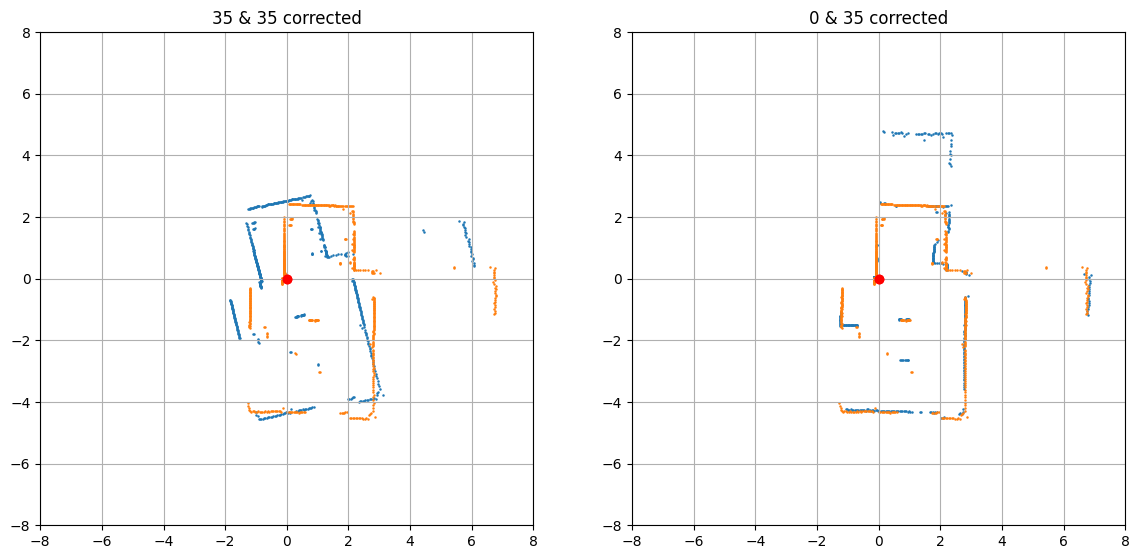

time: 484 ms (started: 2024-11-18 23:12:48 -03:00)


In [20]:
source_idx, target_idx = 35, 0 
_, _, _, source_corrected = correct_cloud(source_idx, target_idx, sor=(5,2.0), verbose=True)

# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,10))
plot_2d(dfs[source_idx].x, dfs[source_idx].y,  "", ax1)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{source_idx} & {source_idx} corrected", ax1)
ax1.grid()

plot_2d(dfs[target_idx].x, dfs[target_idx].y, "", ax2)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{target_idx} & {source_idx} corrected", ax2)
ax2.grid()
plt.show()

#### Stack transformations

$$
\begin{bmatrix}
X_{i} \\
Y_{i} \\
Z_{i} \\
1
\end{bmatrix} = 
_{i}{\left[T\right]}_{i+1}
\begin{bmatrix}
X_{i+1} \\
Y_{i+1} \\
Z_{i+1} \\
1
\end{bmatrix} 
$$

Where:
- $_{i}{\left[T\right]}_{i+1}$ is the transformation matrix from point cloud $i+1$ to point cloud $i$.

To transform a 3D point in point cloud 2 to point cloud 0:

$$
_{0}{\left[T\right]}_{2} = _{0}{\left[T\right]}_{1} \cdot _{1}{\left[T\right]}_{2}
$$

To transform a 3D point in nth point cloud to point cloud 0:

$$
_{0}{\left[T\right]}_{n} = _{0}{\left[T\right]}_{1} \cdot _{1}{\left[T\right]}_{2} \ \dots \  _{n-1}{\left[T\right]}_{n}
$$

cloud 1 to 0: RMSE=0.012, Fit=1.000
cloud 2 to 1: RMSE=0.021, Fit=0.996
cloud 3 to 2: RMSE=0.025, Fit=0.989
cloud 4 to 3: RMSE=0.029, Fit=0.987
cloud 5 to 4: RMSE=0.016, Fit=1.000
cloud 6 to 5: RMSE=0.016, Fit=1.000
cloud 7 to 6: RMSE=0.035, Fit=0.988
cloud 8 to 7: RMSE=0.019, Fit=1.000
cloud 9 to 8: RMSE=0.021, Fit=0.988
cloud 10 to 9: RMSE=0.016, Fit=1.000
cloud 11 to 10: RMSE=0.022, Fit=0.993
cloud 12 to 11: RMSE=0.022, Fit=1.000
cloud 13 to 12: RMSE=0.038, Fit=0.964
cloud 14 to 13: RMSE=0.028, Fit=0.971
cloud 15 to 14: RMSE=0.032, Fit=1.000
cloud 16 to 15: RMSE=0.016, Fit=1.000
cloud 17 to 16: RMSE=0.022, Fit=1.000
cloud 18 to 17: RMSE=0.037, Fit=0.982
cloud 19 to 18: RMSE=0.014, Fit=0.988
cloud 20 to 19: RMSE=0.026, Fit=1.000
cloud 21 to 20: RMSE=0.014, Fit=1.000
cloud 22 to 21: RMSE=0.014, Fit=0.993
cloud 23 to 22: RMSE=0.036, Fit=0.904
cloud 24 to 23: RMSE=0.040, Fit=0.965
cloud 25 to 24: RMSE=0.025, Fit=0.998
cloud 26 to 25: RMSE=0.028, Fit=1.000
cloud 27 to 26: RMSE=0.048, Fit

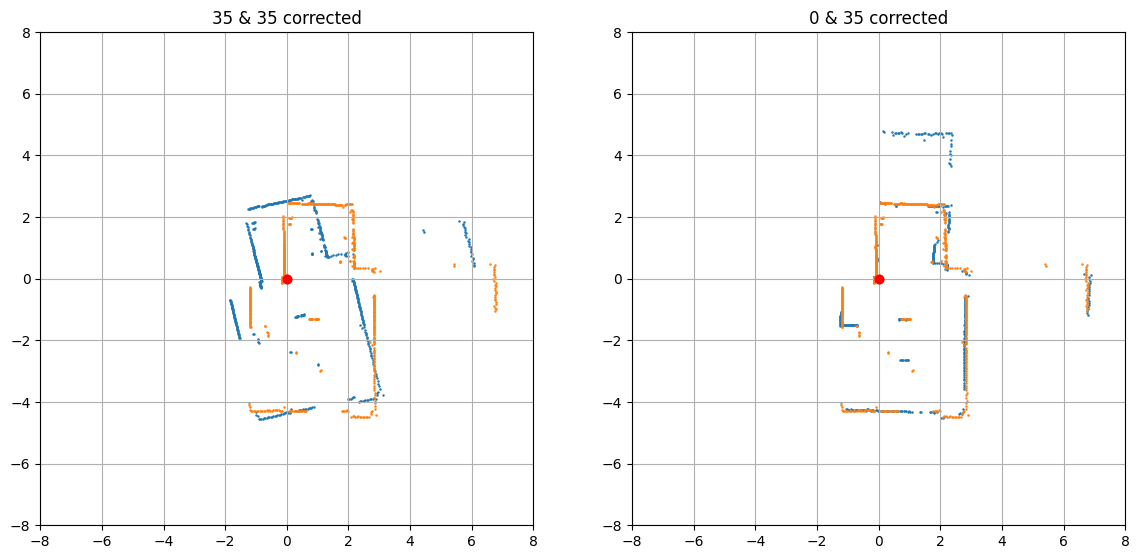

time: 593 ms (started: 2024-11-18 23:13:41 -03:00)


In [ ]:
# Transform one by one and stack trasnformations
trans_init = np.eye(4)
init = 0
end = 35
for i in range(init,end):

    source_idx, target_idx = i+1, i 
    fitness, rmse, trans_local, source_corrected = correct_cloud(source_idx, target_idx, sor=(5,2.0), verbose=False)
    print(f"cloud {i+1} to {i}: RMSE={rmse:.3f}, Fit={fitness:.3f}")

    if len(trans_local)!=0:
        trans_init = trans_init @ trans_local

source_array = dfs[end].to_numpy()
source_corrected = transform(trans_init, source_array)
# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,10))
plot_2d(dfs[end].x, dfs[end].y,  "", ax1)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{end} & {end} corrected", ax1)
ax1.grid()

plot_2d(dfs[init].x, dfs[init].y, "", ax2)
plot_2d(source_corrected[0,:], source_corrected[1,:], f"{init} & {end} corrected", ax2)
ax2.grid()
plt.show()

#### Apply ICP to all clouds

 18%|█▊        | 29/159 [00:00<00:00, 263.70it/s]

cloud 1 to 0: RMSE=0.016, Fit=1.000
cloud 2 to 1: RMSE=0.026, Fit=0.997
cloud 3 to 2: RMSE=0.022, Fit=0.998
cloud 4 to 3: RMSE=0.027, Fit=0.995
cloud 5 to 4: RMSE=0.025, Fit=1.000
cloud 6 to 5: RMSE=0.020, Fit=1.000
cloud 7 to 6: RMSE=0.022, Fit=0.998
cloud 8 to 7: RMSE=0.023, Fit=1.000
cloud 9 to 8: RMSE=0.025, Fit=1.000
cloud 10 to 9: RMSE=0.014, Fit=0.997
cloud 11 to 10: RMSE=0.027, Fit=0.998
cloud 12 to 11: RMSE=0.022, Fit=1.000
cloud 13 to 12: RMSE=0.034, Fit=0.971
cloud 14 to 13: RMSE=0.041, Fit=0.993
cloud 15 to 14: RMSE=0.030, Fit=1.000
cloud 16 to 15: RMSE=0.018, Fit=1.000
cloud 17 to 16: RMSE=0.019, Fit=1.000
cloud 18 to 17: RMSE=0.039, Fit=0.980
cloud 19 to 18: RMSE=0.019, Fit=0.988
cloud 20 to 19: RMSE=0.029, Fit=0.997
cloud 21 to 20: RMSE=0.018, Fit=1.000
cloud 22 to 21: RMSE=0.015, Fit=0.988
cloud 23 to 22: RMSE=0.049, Fit=0.930
cloud 24 to 23: RMSE=0.040, Fit=0.984
cloud 25 to 24: RMSE=0.030, Fit=1.000
cloud 26 to 25: RMSE=0.028, Fit=0.995
cloud 27 to 26: RMSE=0.045, Fit

 52%|█████▏    | 83/159 [00:00<00:00, 233.01it/s]

cloud 53 to 52: RMSE=0.053, Fit=0.985
cloud 54 to 53: RMSE=0.038, Fit=0.992
cloud 55 to 54: RMSE=0.037, Fit=0.997
cloud 56 to 55: RMSE=0.047, Fit=0.994
cloud 57 to 56: RMSE=0.028, Fit=0.994
cloud 58 to 57: RMSE=0.040, Fit=1.000
cloud 59 to 58: RMSE=0.038, Fit=0.982
cloud 60 to 59: RMSE=0.030, Fit=0.984
cloud 61 to 60: RMSE=0.040, Fit=0.998
cloud 62 to 61: RMSE=0.027, Fit=1.000
cloud 63 to 62: RMSE=0.039, Fit=0.994
cloud 64 to 63: RMSE=0.036, Fit=0.997
cloud 65 to 64: RMSE=0.028, Fit=0.991
cloud 66 to 65: RMSE=0.035, Fit=0.997
cloud 67 to 66: RMSE=0.038, Fit=0.992
cloud 68 to 67: RMSE=0.029, Fit=0.983
cloud 69 to 68: RMSE=0.035, Fit=0.995
cloud 70 to 69: RMSE=0.032, Fit=0.994
cloud 71 to 70: RMSE=0.033, Fit=0.998
cloud 72 to 71: RMSE=0.038, Fit=0.987
cloud 73 to 72: RMSE=0.034, Fit=0.995
cloud 74 to 73: RMSE=0.036, Fit=0.994
cloud 75 to 74: RMSE=0.034, Fit=0.991
cloud 76 to 75: RMSE=0.034, Fit=0.998
cloud 77 to 76: RMSE=0.034, Fit=0.998
cloud 78 to 77: RMSE=0.027, Fit=0.988
cloud 79 to 

 67%|██████▋   | 107/159 [00:00<00:00, 190.73it/s]

cloud 96 to 95: RMSE=0.017, Fit=0.977
cloud 97 to 96: RMSE=0.034, Fit=0.989
cloud 98 to 97: RMSE=0.027, Fit=0.985
cloud 99 to 98: RMSE=0.036, Fit=0.998
cloud 100 to 99: RMSE=0.030, Fit=0.986
cloud 101 to 100: RMSE=0.047, Fit=0.977
cloud 102 to 101: RMSE=0.037, Fit=0.986
cloud 103 to 102: RMSE=0.037, Fit=0.995
cloud 104 to 103: RMSE=0.039, Fit=0.991
cloud 105 to 104: RMSE=0.038, Fit=0.991
cloud 106 to 105: RMSE=0.043, Fit=0.998
cloud 107 to 106: RMSE=0.029, Fit=0.998
cloud 108 to 107: RMSE=0.038, Fit=0.998
cloud 109 to 108: RMSE=0.027, Fit=0.995
cloud 110 to 109: RMSE=0.038, Fit=0.991
cloud 111 to 110: RMSE=0.033, Fit=0.992
cloud 112 to 111: RMSE=0.039, Fit=0.987
cloud 113 to 112: RMSE=0.030, Fit=0.997
cloud 114 to 113: RMSE=0.029, Fit=1.000
cloud 115 to 114: RMSE=0.027, Fit=0.995
cloud 116 to 115: RMSE=0.030, Fit=1.000
cloud 117 to 116: RMSE=0.032, Fit=0.997
cloud 118 to 117: RMSE=0.026, Fit=0.998
cloud 119 to 118: RMSE=0.032, Fit=0.998
cloud 120 to 119: RMSE=0.029, Fit=0.998
cloud 121

100%|██████████| 159/159 [00:00<00:00, 199.54it/s]

cloud 127 to 126: RMSE=0.023, Fit=0.995
cloud 128 to 127: RMSE=0.030, Fit=0.990
cloud 129 to 128: RMSE=0.032, Fit=0.997
cloud 130 to 129: RMSE=0.027, Fit=0.989
cloud 131 to 130: RMSE=0.035, Fit=0.977
cloud 132 to 131: RMSE=0.054, Fit=0.981
cloud 133 to 132: RMSE=0.038, Fit=0.998
cloud 134 to 133: RMSE=0.034, Fit=0.998
cloud 135 to 134: RMSE=0.034, Fit=0.997
cloud 136 to 135: RMSE=0.036, Fit=0.989
cloud 137 to 136: RMSE=0.041, Fit=0.987
cloud 138 to 137: RMSE=0.043, Fit=0.990
cloud 139 to 138: RMSE=0.035, Fit=0.990
cloud 140 to 139: RMSE=0.042, Fit=0.998
cloud 141 to 140: RMSE=0.033, Fit=0.997
cloud 142 to 141: RMSE=0.030, Fit=0.984
cloud 143 to 142: RMSE=0.030, Fit=0.995
cloud 144 to 143: RMSE=0.033, Fit=1.000
cloud 145 to 144: RMSE=0.028, Fit=0.992
cloud 146 to 145: RMSE=0.031, Fit=1.000
cloud 147 to 146: RMSE=0.031, Fit=0.992
cloud 148 to 147: RMSE=0.027, Fit=1.000
cloud 149 to 148: RMSE=0.023, Fit=0.998
cloud 150 to 149: RMSE=0.030, Fit=0.990
cloud 151 to 150: RMSE=0.030, Fit=0.998


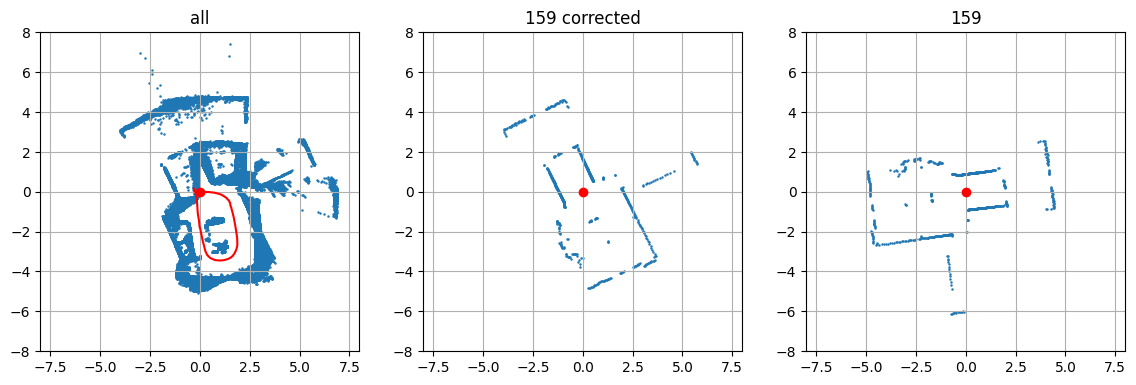

time: 1.2 s (started: 2024-11-18 23:32:10 -03:00)


In [36]:
# initialization
trans_init = np.eye(4)
threshold = 0.2
dfs_corrected = []
dfs_corrected.append(dfs[0])
poses = []

end = len(dfs)-1 
for i in tqdm(range(end)):

    source_idx, target_idx = i+1, i 
    fitness, rmse, trans_local, source_corrected = correct_cloud(source_idx, target_idx, verbose=False)
    print(f"cloud {i+1} to {i}: RMSE={rmse:.3f}, Fit={fitness:.3f}")

    if len(trans_local)!=0:
        trans_init = trans_init @ trans_local
        poses.append(trans_init[:2,3])
    else:
        continue

    source_array = dfs[source_idx].to_numpy()
    source_corrected = transform(trans_init, source_array)

    # Append results
    df3 = pd.DataFrame(source_corrected.T, columns =['x', 'y', 'z', 'ones']) 
    dfs_corrected.append(df3)

poses = np.array(poses)
all_corrected_dfs = pd.DataFrame()
for i in range(len(dfs_corrected)):
    all_corrected_dfs = pd.concat( (all_corrected_dfs, dfs_corrected[i]), ignore_index=True )

fig , (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(14,10))
plot_2d(all_corrected_dfs.x, all_corrected_dfs.y, "all", ax1)
ax1.plot(poses[:,0],poses[:,1], color="red")
plot_2d(dfs_corrected[end].x, dfs_corrected[end].y, f"{end} corrected", ax2)
plot_2d(dfs[end].x, dfs[end].y, end, ax3)
plt.show()

In [34]:
poses

array([[ 2.20402273e-03,  8.27349796e-04],
       [ 3.64026214e-03, -3.34205303e-03],
       [ 5.95727423e-04,  2.46972281e-03],
       [ 9.82242724e-04,  3.25521882e-03],
       [-1.15894707e-03,  2.90646860e-03],
       [-3.71865097e-03,  4.38543445e-03],
       [-4.03425588e-03,  6.36273703e-03],
       [-3.82010566e-03,  6.56673737e-03],
       [-6.06694078e-03,  1.06759129e-02],
       [-7.48747177e-03,  7.83593380e-03],
       [-2.85276927e-03,  1.21748694e-02],
       [-2.08028767e-03,  5.32104475e-03],
       [-1.07024068e-03,  1.38536969e-02],
       [ 4.69878579e-03,  1.02264284e-02],
       [ 1.00098665e-03,  7.24380023e-03],
       [-2.71705025e-04,  7.10744686e-03],
       [ 2.37223804e-03,  7.85571629e-03],
       [-1.23945153e-03,  9.36186001e-03],
       [-1.52437715e-03,  1.22843989e-02],
       [-2.01877907e-03,  1.71551529e-02],
       [-1.65462606e-03,  1.42411200e-02],
       [-5.49129997e-04,  1.33220009e-02],
       [ 7.83392879e-03,  1.01028141e-02],
       [ 2.

time: 16 ms (started: 2024-11-18 23:31:09 -03:00)


#### Check where errors started accumulating

In [42]:
# Initialize the figure and axis
fig , (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(14,10))
scatter1 = ax1.scatter([], [], s=0.6)
scatter2 = ax2.scatter([], [], s=0.6)
scatter3 = ax3.scatter([], [], s=0.6)
ax1.plot(0, 0, 'ro')
ln, = ax1.plot([], [], color='red')
ax1.set_ylim(-8, 8)
ax1.set_xlim(-8, 8)
ax1.set_aspect('equal')
ax1.grid(True)
title1 = ax1.set_title("")
ax2.plot(0, 0, 'ro')
ax2.set_ylim(-8, 8)
ax2.set_xlim(-8, 8)
ax2.set_aspect('equal')
ax2.grid(True)
title2 = ax2.set_title("")
ax3.plot(0, 0, 'ro')
ax3.set_ylim(-8, 8)
ax3.set_xlim(-8, 8)
ax3.set_aspect('equal')
ax3.grid(True)
title3 = ax3.set_title("")

# Update function for animation
all_corrected_dfs = pd.DataFrame()
def update(frame):
    global all_corrected_dfs
    all_corrected_dfs = pd.concat( (all_corrected_dfs, dfs_corrected[frame]), ignore_index=True )
    scatter1.set_offsets(all_corrected_dfs[['x', 'y']].values)
    scatter2.set_offsets(dfs_corrected[frame][['x', 'y']].values)
    scatter3.set_offsets(dfs[frame][['x', 'y']].values)
    
    title1.set_text(f"Point Cloud: all / Cloud Size: {len(all_corrected_dfs)}")
    title2.set_text(f"Cloud: {frame} corrected / Cloud size: {len(dfs_corrected[frame])}")
    title3.set_text(f"Cloud: {frame} / Cloud size: {len(dfs[frame])}")

    ln.set_data(poses[0:frame, 0], poses[0:frame, 1])
    return scatter1, scatter2, scatter3, title1, title2, title3, ln

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(dfs_corrected), blit=False, repeat=False
)

# Save the animation as MP4
ani.save('imgs/scatter_animation2.mp4', fps=10, extra_args=['-vcodec', 'libx264'])

plt.close(fig)

time: 33.7 s (started: 2024-11-18 23:43:08 -03:00)


Result: <a href="imgs/scatter_animation2.mp4">imgs/scatter_animation2.mp4</a>